Grid Search with Mia's dataset

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import pickle 

In [2]:
# with open('cleaned_df_test.pkl', "rb") as f:
#     cleaned_df_test= pickle.load(f)
    
# with open('cleaned_df_train.pkl', "rb") as f2:
#     cleaned_df_train= pickle.load(f2)
    
# with open('y_train.pkl', "rb") as f3:
#     y_train= pickle.load(f3)

# with open('y_test.pkl', "rb") as f4:
#     y_test= pickle.load(f4)  

In [13]:
df = pd.read_pickle('dropped_na_data.pickle')

# Data Cleaning

In [14]:
unknown= df.loc[(df['population']==0)&(df['construction_year']==0)&(df['amount_tsh']==0)&(df['gps_height']==0)]

In [15]:
def missing(row): 
    if (row['population']==0)&(row['construction_year']==0)&(row['amount_tsh']==0)&(row['gps_height']==0):
        return 1
    else:
        return 0 


In [16]:
df['missing']= df.apply(lambda row : missing(row), axis=1)

In [17]:
X = df.drop('status_group', axis=1)
X.shape

(59400, 19)

In [18]:
y= df['status_group']

In [21]:
le = LabelEncoder()

In [22]:
y=le.fit_transform(df['status_group'])

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=42, stratify=y)

In [26]:
cat_columns= [col for col in X.columns if X[col].dtype in ['object']]

In [27]:
num_columns = [col for col in X.columns if X[col].dtypes in ['float64', 'int64']]

num_columns

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'district_code',
 'population',
 'construction_year',
 'missing']

In [28]:
zero_pipe=Pipeline(steps= [
    ('ss', StandardScaler())
])

In [29]:
cat_pipe=Pipeline(steps= [
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [32]:
coltran= ColumnTransformer(transformers=[
    ('zero', zero_pipe , num_columns), 
    ('cat_pipe', cat_pipe, cat_columns)
],remainder= 'passthrough')


# Simple Models

In [3]:
#function for evaluating a model
def evaluate_model(model, X, y):
    """
    Definition:
    Prints classification report and plots a confusion matrix of a model's performance.
    
    Args:
    model - Model. Can also be a pipeline object.
    X - Features.
    y - Target.
    
    Returns:
    Prints classification report and plots a confusion matrix.
    """
    # creating predictions
    y_pred = model.predict(X)
    
    # printing classification report
    print(classification_report(y, y_pred))

    # plotting confusion matrix
    plot_confusion_matrix(
        model, X, y, display_labels=["function", "non functional", "functional needs repair"], 
        xticks_rotation=30, values_format="d",cmap=plt.cm.Blues)  

## Decision Tree

In [34]:
#pipeline - decision tree
tree_pipe = imbpipeline(steps=[
    ('coltran', coltran),
    ('smote', SMOTE()),
    ('tree', DecisionTreeClassifier())
])

#decision tree baseline model
%time
tree_pipe.fit(X_train, y_train)
tree_pipe.score(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


0.9963594276094276

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      6452
           1       0.35      0.41      0.38       863
           2       0.77      0.77      0.77      4565

    accuracy                           0.75     11880
   macro avg       0.64      0.66      0.65     11880
weighted avg       0.76      0.75      0.76     11880



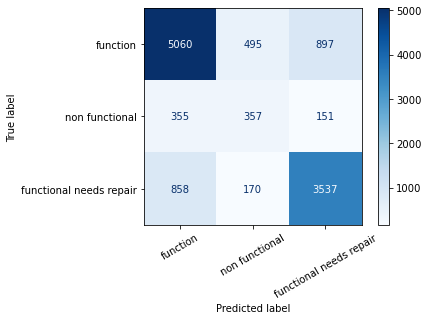

In [35]:
evaluate_model(tree_pipe, X_test, y_test)

## Random Forest

In [36]:
#pipeline - random forest
forest_pipe = imbpipeline(steps=[
    ('coltran', coltran),
    ('smote', SMOTE()),
    ('forest', RandomForestClassifier())
])

#random forest baseline model
%time
forest_pipe.fit(X_train, y_train)
forest_pipe.score(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


0.9963594276094276

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      6452
           1       0.43      0.45      0.44       863
           2       0.83      0.80      0.81      4565

    accuracy                           0.80     11880
   macro avg       0.69      0.70      0.70     11880
weighted avg       0.80      0.80      0.80     11880



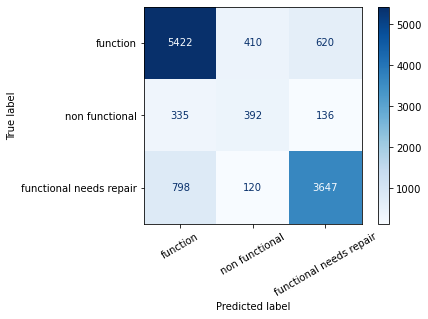

In [37]:
evaluate_model(forest_pipe, X_test, y_test)

## XG Boosting

In [38]:
#pipeline - xg boosting
xg_pipe = imbpipeline(steps=[
    ('coltran', coltran),
    ('smote', SMOTE()),
    ('xg', XGBClassifier())
])

#xg boosting baseline model
%time
xg_pipe.fit(X_train, y_train)
xg_pipe.score(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


0.7826809764309764

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      6452
           1       0.32      0.60      0.42       863
           2       0.83      0.73      0.78      4565

    accuracy                           0.75     11880
   macro avg       0.65      0.71      0.66     11880
weighted avg       0.78      0.75      0.76     11880



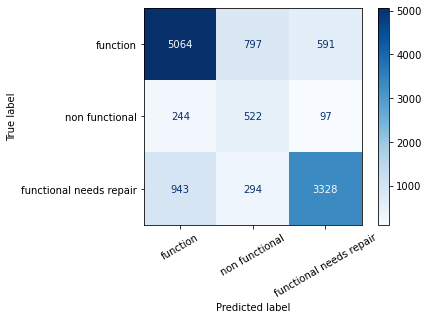

In [39]:
evaluate_model(xg_pipe, X_test, y_test)

## Gradient Boosting

In [41]:
#pipeline - gradient boosting
gb_pipe = imbpipeline(steps=[
    ('coltran', coltran),
    ('smote', SMOTE()),
    ('gb', GradientBoostingClassifier())
])

#gradient boosting baseline model
%time
gb_pipe.fit(X_train, y_train)
gb_pipe.score(X_train, y_train)

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      6452
           1       0.24      0.60      0.34       863
           2       0.81      0.64      0.72      4565

    accuracy                           0.69     11880
   macro avg       0.61      0.66      0.61     11880
weighted avg       0.75      0.69      0.71     11880



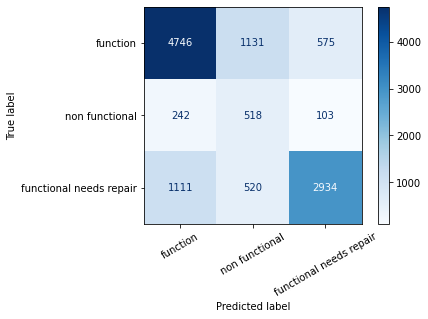

In [19]:
evaluate_model(gb_pipe, X_test, y_test)

# Grid Search

## Random Forest

In [21]:
#random forest grid 1
forest_param_grid1 = {
    'forest__max_depth': [20, 30],
    'forest__min_samples_split': [2, 3, 5],
    'forest__min_samples_leaf': [1, 2]
}

gs_forest1 = GridSearchCV(forest_pipe, forest_param_grid1, cv=2)

%time
gs_forest1.fit(X_train, y_train)

gs_forest1.best_params_

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 17.9 µs


{'forest__max_depth': 30,
 'forest__min_samples_leaf': 1,
 'forest__min_samples_split': 2}

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     25807
           1       0.68      0.92      0.78      3454
           2       0.97      0.92      0.94     18259

    accuracy                           0.93     47520
   macro avg       0.87      0.93      0.89     47520
weighted avg       0.94      0.93      0.93     47520



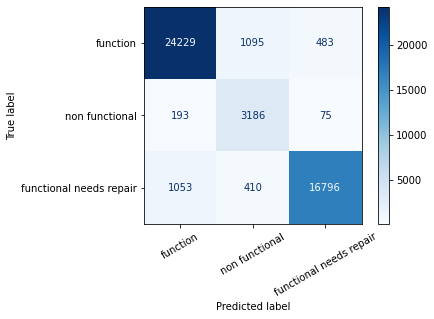

In [22]:
#classification report
evaluate_model(gs_forest1.best_estimator_, X_train, y_train)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      6452
           1       0.37      0.56      0.45       863
           2       0.84      0.78      0.81      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.72      0.69     11880
weighted avg       0.80      0.78      0.79     11880



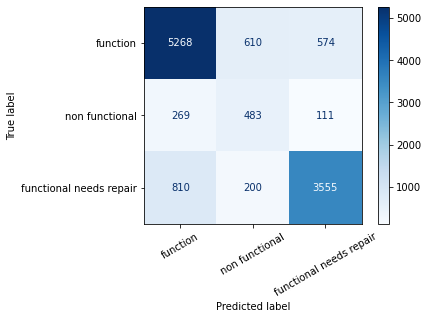

In [23]:
evaluate_model(gs_forest1.best_estimator_, X_test, y_test)

In [6]:
#random forest grid 2
forest_param_grid2 = {
    'forest__max_depth': [5],
    'forest__min_samples_split': [2, 3, 5],
    'forest__min_samples_leaf': [1, 2]
}

gs_forest2 = GridSearchCV(forest_pipe, forest_param_grid2, cv=2)

%time
gs_forest2.fit(X_train, y_train)

gs_forest2.best_params_

CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 11 µs


{'forest__max_depth': 5,
 'forest__min_samples_leaf': 2,
 'forest__min_samples_split': 2}

              precision    recall  f1-score   support

           0       0.77      0.63      0.69     25807
           1       0.20      0.56      0.29      3454
           2       0.70      0.63      0.66     18259

    accuracy                           0.62     47520
   macro avg       0.55      0.61      0.55     47520
weighted avg       0.70      0.62      0.65     47520



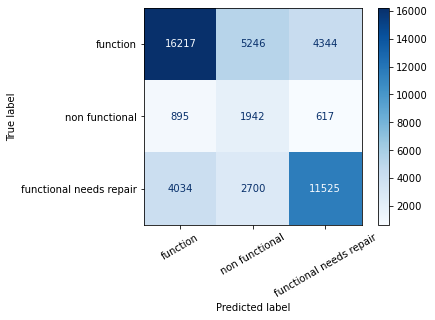

In [8]:
#classification report
evaluate_model(gs_forest2.best_estimator_, X_train, y_train)

              precision    recall  f1-score   support

           0       0.76      0.63      0.69      6452
           1       0.19      0.53      0.28       863
           2       0.70      0.63      0.66      4565

    accuracy                           0.62     11880
   macro avg       0.55      0.59      0.54     11880
weighted avg       0.69      0.62      0.65     11880



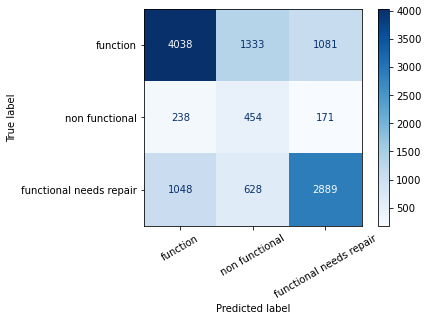

In [9]:
evaluate_model(gs_forest2.best_estimator_, X_test, y_test)

## XG Boosting

In [24]:
#xg grid 1
xg_param_grid1 = {
    'xg__learning_rate': [0.1, 0.2],
    'xg__max_depth': [6],
    'xg__min_child_weight': [1, 2],
    'xg__subsample': [0.5, 0.7, 1],
    'xg__n_estimators': [100],
}

gs_xg1 = GridSearchCV(xg_pipe, xg_param_grid1, cv=2)

%time
gs_xg1.fit(X_train, y_train)

gs_xg1.best_params_

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:37:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:39:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:41:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:43:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:45:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:47:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:58:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:12:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:15:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:20:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:29:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:31:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/semc/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:33:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'xg__learning_rate': 0.2,
 'xg__max_depth': 6,
 'xg__min_child_weight': 1,
 'xg__n_estimators': 100,
 'xg__subsample': 0.5}

              precision    recall  f1-score   support

           0       0.83      0.80      0.81     25807
           1       0.35      0.69      0.47      3454
           2       0.85      0.74      0.79     18259

    accuracy                           0.77     47520
   macro avg       0.68      0.74      0.69     47520
weighted avg       0.80      0.77      0.78     47520



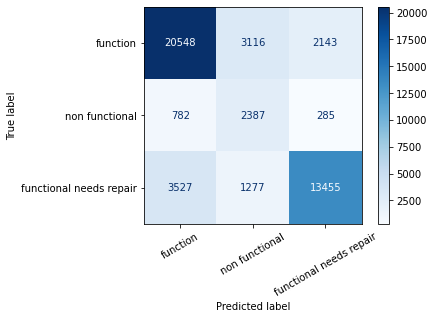

In [25]:
#classification report
evaluate_model(gs_xg1.best_estimator_, X_train, y_train)

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      6452
           1       0.31      0.61      0.41       863
           2       0.83      0.72      0.77      4565

    accuracy                           0.74     11880
   macro avg       0.65      0.70      0.66     11880
weighted avg       0.78      0.74      0.76     11880



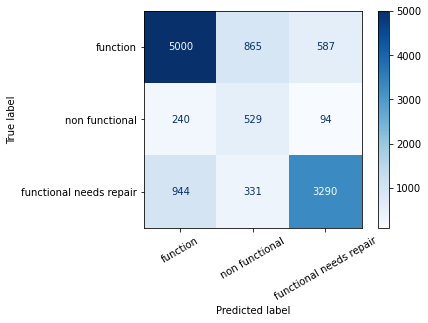

In [26]:
evaluate_model(gs_xg1.best_estimator_, X_test, y_test)

## Gradient Boosting

In [27]:
#xg grid 1
gb_param_grid1 = {
    'gb__learning_rate': [0.1, 0.2],
    'gb__max_depth': [3, 6],
    'gb__subsample': [0.5, 0.7, 1],
}

gs_gb1 = GridSearchCV(gb_pipe, gb_param_grid1, cv=2)

%time
gs_gb1.fit(X_train, y_train)

gs_gb1.best_params_

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 34.1 µs


{'gb__learning_rate': 0.2, 'gb__max_depth': 6, 'gb__subsample': 0.7}

              precision    recall  f1-score   support

           0       0.84      0.83      0.83     25807
           1       0.40      0.70      0.51      3454
           2       0.87      0.76      0.81     18259

    accuracy                           0.79     47520
   macro avg       0.70      0.76      0.72     47520
weighted avg       0.82      0.79      0.80     47520



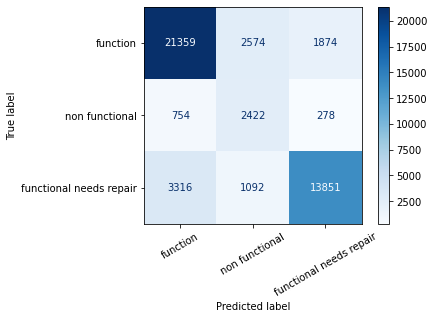

In [28]:
#classification report
evaluate_model(gs_gb1.best_estimator_, X_train, y_train)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6452
           1       0.32      0.59      0.42       863
           2       0.83      0.72      0.77      4565

    accuracy                           0.75     11880
   macro avg       0.65      0.70      0.66     11880
weighted avg       0.78      0.75      0.76     11880



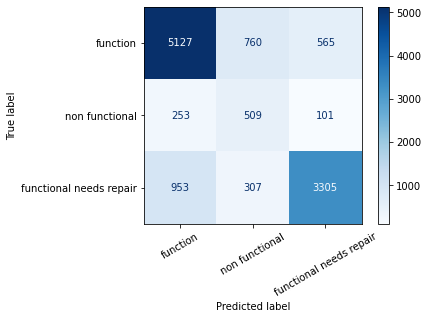

In [29]:
evaluate_model(gs_gb1.best_estimator_, X_test, y_test)